In [1]:
# ! pip install pandas numpy scikit-learn plotly matplotlib
# ! pip install nbformat
# ! pip install --upgrade nbformat
# ! pip install tensorflow[and-cuda]

In [2]:
# ! pip install pandas numpy scikit-learn plotly matplotlib
# ! pip install nbformat
# ! pip install --upgrade nbformat
# ! pip install tensorflow[and-cuda]

## Notes

#### Imports

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime as dt
import glob

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Rescaling, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
import visualkeras

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import warnings 
warnings.filterwarnings('ignore')

2024-10-13 15:44:59.137746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 15:44:59.149207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 15:44:59.152842: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 15:44:59.162359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 15:44:59.977758: W tensorflow/compiler/tf2

In [4]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1728827101.453882   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728827101.490924   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728827101.491145   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


#### Train/test sets

In [5]:
DATASET_FOLDER_TRAIN = 'CIFAKE/train'
DATASET_FOLDER_TEST = 'CIFAKE/test'

BATCH_SIZE = 24
COLOR_MODE = 'grayscale'
CLASS_MODE = 'binary'
TARGET_SIZE = (32, 32)
LEARN_RATE = 0.0001
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,  
    # vertical_flip=True,  
    validation_split=0.2,  
)

# Load training data from directory and apply transformations
train_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER_TRAIN,  
    target_size=TARGET_SIZE,    
    color_mode=COLOR_MODE,  
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,  
    subset='training', 
    seed = SEED
)

# Load validation data (20% of the training data)
validation_generator = train_datagen.flow_from_directory(
    DATASET_FOLDER_TRAIN, 
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation', 
    shuffle=False,
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    DATASET_FOLDER_TEST,  
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


#### EDA

In [6]:
# train_generator.num_classes
# validation_generator.num_classes
# pd.DataFrame(  list( test_generator.filepaths)  )

# pd.DataFrame( validation_generator.filepaths )

In [7]:
print('Class distribution: ')
print( f'Train REAL images: {len(glob.glob('CIFAKE/train/REAL/*'))}'  )
print( f'Train FAKE images: {len(glob.glob('CIFAKE/train/FAKE/*'))}'  )

print( f'Test REAL images: {len(glob.glob('CIFAKE/test/REAL/*'))}'  )
print( f'Test FAKE images: {len(glob.glob('CIFAKE/test/FAKE/*'))}'  )

Class distribution: 
Train REAL images: 50000
Train FAKE images: 50000
Test REAL images: 10000
Test FAKE images: 10000


In [8]:
# Show random image

#### Image normalisation

In [9]:
# Image normalisation

#### Build model

In [10]:
# Build model
# https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet    VGG-19

def CNN_model01():
    model = Sequential([
        Input(shape=train_generator.image_shape), 

        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        # MaxPooling2D(),
        
        Conv2D(64, 3, activation='relu', padding='same'),
        # MaxPooling2D(),

        Conv2D(128, 3, activation='relu', padding='same'),
        # Conv2D(128, 3, activation='relu', padding='same'),


        # Conv2D(256, 3, activation='relu', padding='same'),
        # Conv2D(256, 3, activation='relu'),
        # Conv2D(256, 3, activation='relu'),
        # Conv2D(256, 3, activation='relu'),

        # Conv2D(512, 3, activation='relu'),
        # Conv2D(512, 3, activation='relu'),
        # Conv2D(512, 3, activation='relu'),
        # Conv2D(512, 3, activation='relu'),

        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile( optimizer=Adam(learning_rate=LEARN_RATE), 
                  loss=BinaryCrossentropy(),
                  metrics = ['accuracy', Precision(), Recall()],               
                  )

    return model

I0000 00:00:1728827102.836804   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728827102.837009   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728827102.837164   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728827102.892279   19369 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

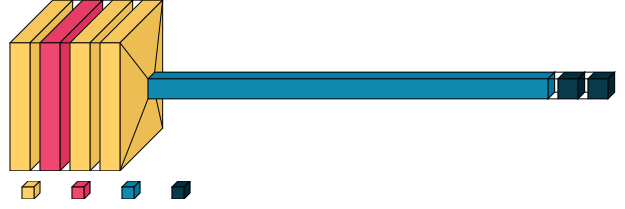

In [11]:
visualkeras.layered_view(CNN_model01(), legend=True)

#### Train model

In [12]:
N_EPOCHS = 5

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model = CNN_model01()

In [13]:
history = model.fit(train_generator, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_data=(validation_generator),
                    callbacks=[early_stopping]
                    )

Epoch 1/5


I0000 00:00:1728827104.513628   19685 service.cc:146] XLA service 0x76bd180040d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728827104.513644   19685 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-10-13 15:45:04.545583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 15:45:04.691741: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  21/3334 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.4644 - loss: 0.7555 - precision_1: 0.4805 - recall_1: 0.7356

2024-10-13 15:45:06.389771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728827106.395340   19685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2029/3334 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7949 - loss: 0.4273 - precision_1: 0.7917 - recall_1: 0.8021

2024-10-13 15:45:24.375459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



3334/3334 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8215 - loss: 0.3841 - precision_1: 0.8195 - recall_1: 0.8255 - val_accuracy: 0.9020 - val_loss: 0.2445 - val_precision_1: 0.8659 - val_recall_1: 0.9512
Epoch 2/5
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9209 - loss: 0.2039 - precision_1: 0.9231 - recall_1: 0.9178 - val_accuracy: 0.9295 - val_loss: 0.1812 - val_precision_1: 0.9341 - val_recall_1: 0.9242
Epoch 3/5
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9375 - loss: 0.1631 - precision_1: 0.9421 - recall_1: 0.9323 - val_accuracy: 0.9325 - val_loss: 0.1768 - val_precision_1: 0.9136 - val_recall_1: 0.9553
Epoch 4/5
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.9489 - loss: 0.1366 - precision_1: 0.9516 - recall_1: 0.9460 - val_accuracy: 0.9363 - val_loss: 0.1688 - val_precision_1: 0.9207 - val_recall_1: 0.9550
Epoch 5/5
3334/3334 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9568 - loss: 0.1150 - precision_1: 0.9584 - recall_1: 0.95

In [17]:
hist = history.history
cols = list(history.history.keys())
cols

['accuracy',
 'loss',
 'precision_1',
 'recall_1',
 'val_accuracy',
 'val_loss',
 'val_precision_1',
 'val_recall_1']

In [18]:
n = int(cols[3][-1])

dict_ = {   'loss' : hist['loss'],
         'accuracy' : hist[f'accuracy'],
         'precision' : hist[f'precision_{n}'],
         'recall' : hist[f'recall_{n}'],
         'val_loss' : hist['val_loss'],
         'val_accuracy' : hist[f'val_accuracy'],
         'val_precision' : hist[f'val_precision_{n}'],
         'val_recall' : hist[f'val_recall_{n}']

}
hist = pd.DataFrame(dict_)

## Evaluation

In [35]:
fig_metrics = make_subplots(rows=2, cols=2, subplot_titles=("Loss", f"Precision", "Accuracy", "Recall"), vertical_spacing=0.07)

# Loss
fig_metrics.add_trace( go.Scatter(x=list(range(len(hist['loss']))), y=hist['loss'], mode='lines+markers', name='Training Loss'), row=1, col=1 )
fig_metrics.add_trace( go.Scatter(x=list(range(len(hist['val_loss']))), y=hist['val_loss'], mode='lines+markers', name='Validation Loss'), row=1, col=1 )

# Precision
fig_metrics.add_trace(  go.Scatter(x=list(range(len(hist['precision']))), y=hist['precision'],  mode='lines+markers', name=f'Training precision'),  row=1, col=2 )
fig_metrics.add_trace( go.Scatter(x=list(range(len(hist['val_precision']))), y=hist['val_precision'], mode='lines+markers', name=f'Validation precision'), row=1, col=2)

# Accuracy
fig_metrics.add_trace(  go.Scatter(x=list(range(len(hist['accuracy']))), y=hist['accuracy'],  mode='lines+markers', name=f'Training accuracy'),  row=2, col=1 )
fig_metrics.add_trace( go.Scatter(x=list(range(len(hist['val_accuracy']))), y=hist['val_accuracy'], mode='lines+markers', name=f'Validation accuracy'), row=2, col=1)

# Recall
fig_metrics.add_trace(  go.Scatter(x=list(range(len(hist['recall']))), y=hist['recall'],  mode='lines+markers', name=f'Training recall'),  row=2, col=2 )
fig_metrics.add_trace( go.Scatter(x=list(range(len(hist['val_recall']))), y=hist['val_recall'], mode='lines+markers', name=f'Validation recall'), row=2, col=2)

# fig.update_xaxes(title_text="Epochs", row=1, col=1)
fig_metrics.update_yaxes(title_text="Loss", row=1, col=1)
fig_metrics.update_yaxes(title_text=f"Precision", row=1, col=2)
fig_metrics.update_yaxes(title_text=f"Accuracy", row=2, col=1)
fig_metrics.update_yaxes(title_text=f"Recall", row=2, col=2)

fig_metrics.update_layout(
    # title_text="Training and validation metrics over epochs",
    showlegend=True,
    margin=dict(l=10, r=10, b=10, t=30),
    width=1400, height=800
)

for annotation in fig_metrics['layout']['annotations']:
    annotation['y'] = annotation['y'] + 0.002

In [36]:
# Evaluate the model on test data
test_loss, test_acc, test_prec, test_recall = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

833/833 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9415 - loss: 0.1583 - precision_1: 0.9469 - recall_1: 0.9346


In [61]:
from sklearn.metrics import confusion_matrix

# Get the true and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix  # FIXME 
cm = confusion_matrix(y_true, y_pred_classes)

834/834 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


(array([0, 0, 0, ..., 1, 1, 1], dtype=int32), array([0, 0, 0, ..., 0, 0, 0]))

In [59]:
class_labels = list(test_generator.class_indices.keys())

# Plotly heatmap for confusion matrix
fig_confMatrix = go.Figure(data=go.Heatmap(
    z=cm,
    x=[] ,  # Predicted labels
    y=class_labels,  # True labels
    hoverongaps=False,
    colorscale='Blues',
    showscale=True,
    text=cm,
    texttemplate="%{text}",
    textfont={"size":15}
))

# Update layout to add labels and title
fig_confMatrix.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=600,
    height=500,
)
print()

fig_confMatrix

In [52]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

In [53]:
y_pred.shape

(20000, 1)

In [54]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Get the true and predicted labels
y_true = test_generator.classes  # True binary labels (0 or 1)
y_pred = model.predict(test_generator)  # Probabilities or predictions


# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve using Plotly
fig_rocauc = go.Figure()

# Add the ROC curve
fig_rocauc.add_trace(go.Scatter(
    x=fpr, y=tpr,
    mode='lines',
    line=dict(color='blue', width=2),
    name=f'ROC curve (AUC = {roc_auc:0.2f})'
))

# Add the diagonal line (random classifier)
fig_rocauc.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip'
))

# Update layout with axis titles and legend
fig_rocauc.update_layout(
    title='ROC AUC for Binary Classification (Mask Detection)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700,
    height=600,
    legend=dict(x=0.6, y=0.1),
    margin=dict(l=40, r=40, t=40, b=40),)
print()

834/834 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step



## Evaluation plots+

In [55]:
# print(hist)
hist

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.299336,0.871713,0.872168,0.871100,0.244455,0.90195,0.865908,0.9512
1,0.195788,0.923400,0.925399,0.921050,0.181159,0.92950,0.934101,0.9242
2,0.161879,0.937925,0.941345,0.934050,0.176778,0.93250,0.913638,0.9553
3,0.137987,0.947513,0.949705,0.945075,0.168803,0.93635,0.920659,0.9550
4,0.115750,0.956950,0.958417,0.955350,0.153792,0.93905,0.946325,0.9309


In [56]:
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall: {test_recall:.4f}")
print()
print('Classification report:')
print(report)   # Test I think

# Plots
fig = make_subplots(
    rows=3, cols=2, 
    subplot_titles=("Loss", "Precision", 
                    "Accuracy", 'Recall',
                    'Confusion Matrix', 'ROC-AUC curve'), 
    # column_widths=[0.4, 0.3, 0.3],  # Adjust column widths to balance space
    horizontal_spacing=0.05, 
    vertical_spacing=0.05  
)

fig.add_trace(fig_metrics['data'][0], row=1, col=1)
fig.add_trace(fig_metrics['data'][1], row=1, col=1)
fig.add_trace(fig_metrics['data'][2], row=1, col=2)
fig.add_trace(fig_metrics['data'][3], row=1, col=2)
fig.add_trace(fig_metrics['data'][4], row=2, col=1)
fig.add_trace(fig_metrics['data'][5], row=2, col=1)
fig.add_trace(fig_metrics['data'][6], row=2, col=2)
fig.add_trace(fig_metrics['data'][7], row=2, col=2)
fig.add_trace(fig_confMatrix['data'][0], row=3, col=1)
fig.add_trace(fig_rocauc['data'][0], row=3, col=2)
fig.add_trace(fig_rocauc['data'][1], row=3, col=2)

fig.update_layout(
    height=400*3, 
    width=1400, 
    # title_text="CNN Model Evaluation: Metrics, Confusion Matrix, and ROC AUC",
    showlegend=False, 
    margin=dict(l=10, r=10, t=50, b=10),  
)

fig.show()

Test loss: 0.1587
Test accuracy: 0.9409
Test precision: 0.9470
Test recall: 0.9341

Classification report:
              precision    recall  f1-score   support

        FAKE       0.50      1.00      0.67     10000
        REAL       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



#### Class activation map